## Preprocessing Qubicc

Converting the data into npy makes it possible for us to work with it efficiently; originally we require 500GB of RAM which is always difficult to guarantee.

1) We read the data
2) Reshape variables so that they have equal dimensionality
3) Remove data above 21kms
4) Reshape into data samples fit for the NN
5) Split into input and output
6) Save as npy in float32

Note: We neither scale nor split the data into training/validation/test sets. <br>
The reason is that i) in order to scale we need the entire dataset but this can only be done in conjunction with the Narval dataset. Also for cross-validation different scalings will be necessary based on different subsets of the data, ii) The split into subsets will be done by the cross-validation procedure or not at all when training the final model.

In [1]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gc 
# import importlib
# importlib.reload(my_classes)

base_path = '/pf/b/b309170'
output_path = base_path + '/my_work/icon-ml_data/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/based_on_var_interpolated_data'

# Add path with my_classes to sys.path
sys.path.insert(0, base_path + '/workspace_icon-ml/cloud_cover_parameterization/')

# Which days to load
days_qubicc = 'all_hcs'

from my_classes import load_data

VERT_LAYERS = 31

# Set output_var to one of {'cl', 'cl_area'}
output_var = 'cl_area'

## 1) Reading the data
### Input:
- fr_land: Fraction of land
- zg: Geometric height at full levels (3D)
- qv: Specific water vapor content (3D)
- qc: Specific cloud water content (3D)
- qi: Specific cloud ice content (3D)
- temp: Temperature (3D)
- pres: Pressure (3D)

$186$ $( = 1+24[zf]+26[q_c]+27\cdot 5$) input nodes

### Output:
- clc: Cloud Cover

$27$ output nodes

The data above 21km is capped.

In [ ]:
# For cl_area I only need the output as I already have the input
# I still need 'clw', 'cli', 'cl' for condensate-free clouds
# If I were to use 'cl_area' for condensate-free clouds I would get an estimate 
# which is slightly different due to coarse-graining

order_of_vars_qubicc = ['hus', 'clw', 'cli', 'ta', 'pfull', 'zg', 'fr_land', output_var]

In [2]:
# Load QUBICC data
data_dict = load_data(source='qubicc', days=days_qubicc, resolution='R02B05', 
                             order_of_vars=order_of_vars_qubicc)

hus
clw
cli
ta
pfull
cl


In [3]:
if output_var == 'cl':
    # Are there any bad data points
    ta_is_0 = np.where(data_dict['ta'] == 0)
    for i in range(3):
        assert ta_is_0[i].size == 0

    del ta_is_0
    gc.collect()

7425

Counting fraction of condensate-free clouds <br>
I'll leave them in the training data for the column-based and region-based models. The reason is that we would have to remove quite a lot around the given grid cell. I can do that in the grid-cell based models.

In [4]:
# clouds = 0
# count_cond_free_clouds = 0
# for i in range(data_dict['cl'].shape[0]):
#     for j in range(data_dict['cl'].shape[1]):
#         for k in range(data_dict['cl'].shape[2]):
#             if (data_dict['cl'][i,j,k] > 0 and data_dict['clw'][i,j,k] + data_dict['cli'][i,j,k] == 0):
#                 count_cond_free_clouds += 1
#             if (data_dict['cl'][i,j,k] > 0):
#                 clouds += 1

In [5]:
# count_cond_free_clouds/clouds

In [6]:
for key in data_dict.keys():
    print(key, data_dict[key].shape)

hus (2162, 31, 78069)
qclw_phy (2162, 31, 78069)
cli (2162, 31, 78069)
ta (2162, 31, 78069)
pfull (2162, 31, 78069)
zg (31, 78069)
fr_land (78069,)
cl (2162, 31, 78069)


In [7]:
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = data_dict['cl'].shape

In [8]:
try:
    #Reshaping into nd-arrays of equaling shapes (don't reshape in the vertical)
    data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), TIME_STEPS, axis=0)
    data_dict['fr_land'] = np.repeat(np.expand_dims(data_dict['fr_land'], 0), TIME_STEPS, axis=0)
except:
    pass

In [9]:
# Remove the first timesteps of the QUBICC simulations since the clc values are 0 across the entire earth there 
remove_steps = []
for i in range(data_dict['cl'].shape[0]):
    if np.all(data_dict['cl'][i,4:,:] == 0):
        remove_steps.append(i)
        TIME_STEPS = TIME_STEPS - 1

for key in data_dict.keys():
    data_dict[key] = np.delete(data_dict[key], remove_steps, axis=0)

In [10]:
# Our Neural Network has trained with clc in [0, 100]!
data_dict[output_var] = 100*data_dict[output_var]
np.max(data_dict[output_var][:, 4:, :])

100.00001192092896

In [11]:
# One sample should contain a column of information
data_dict_reshaped = {}

for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        # Removing data above 21kms
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',(i+17)) # Should start at 21
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

In [12]:
#Modifies df as well
def split_input_output(dataset):
    output_df = {}
    for i in range(21, 48):
        output_df['cl_area_%d'%i] = dataset['cl_area_%d'%i] # Should start at 21
        del dataset['cl_area_%d'%i]
    return output_df

In [13]:
output_dict = split_input_output(data_dict_reshaped)

In [14]:
# Convert dict into np array
data_reshaped = np.array([data_dict_reshaped[j] for j in data_dict_reshaped.keys()])
output = np.array([output_dict[j] for j in output_dict.keys()])

In [15]:
# Save the data
if output_var == 'cl':
    np.save(output_path + '/cloud_cover_input_qubicc.npy', np.float32(data_reshaped))
    np.save(output_path + '/cloud_cover_output_qubicc.npy', np.float32(output))
elif output_var == 'cl_area':
    np.save(output_path + '/cloud_area_output_qubicc.npy', np.float32(output))

In [ ]:
# Test
if output_var == 'cl_area':
    old_input = np.load(output_path + '/cloud_cover_input_qubicc.npy')
    # If this yields True once then we're done
    for i in range(old_input.shape[1]):
        print(np.all(old_input[:,i] == df['qi_25']))

Some tests of the cloud area output

In [2]:
clc = np.load(output_path + '/cloud_cover_output_qubicc.npy')
cl_area = np.load(output_path + '/cloud_area_output_qubicc.npy')

In [3]:
diff = cl_area - clc

In [ ]:
plt.hist(diff, bins = 10)
plt.show()

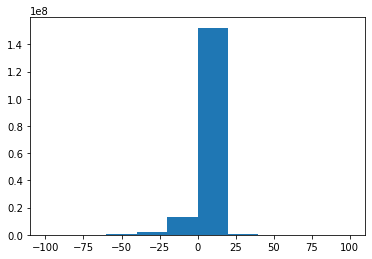

In [20]:
plt.hist(diff[-1], bins = 10)
plt.show()

In [ ]:
plt.hist(diff, bins = 100, log=True)
plt.show()

In [17]:
# These should be anomalies existing due to differences in coarse-graining
len(np.where(diff < 0)[0])

43648060

In [18]:
len(np.where(diff >= 0)[0])

4507228157

In [22]:
len(np.where(diff < 0)[0])/diff.size # 0.96% of the data

0.009591133205722172

In [23]:
len(np.where(diff < 0)[0])/len(np.where(diff != 0)[0]) # 2.46% of cloudy data

0.0245638693192378